In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
import joblib
import japanize_matplotlib
import shap
from scipy import stats
pd.set_option("display.max_columns",None)

In [21]:
results = pd.read_csv("../results/predictions/decision_tree_predictions.csv")
X_test = pd.read_csv("../results/predictions/decision_tree_X_test.csv")
display(results.head())
display(X_test.head())

,Actual,Predicted
0,0.976309,1.000000
1,0.966494,0.888946
2,0.970779,0.960985
3,1.000000,0.784450
4,0.966917,0.910069


,Average_Temperature (℃),Total_Precipitation (mm),Average_wind_speed(m/s),Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Opponent_DeNA,Opponent_オリックス,Opponent_ヤクルト,Opponent_ロッテ,Opponent_中日,Opponent_巨人,Opponent_広島,Opponent_日本ハム,Opponent_楽天,Opponent_西武,Opponent_阪神,Is_Holiday,Match_Number,Rain_Zero_Flag
0,18.1,9.5,2.2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,17.3,62.0,3.2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,2,0
2,14.8,1.5,4.4,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0
3,18.5,0.0,2.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,4,1
4,18.2,7.5,2.8,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0


<Figure size 2000x1000 with 0 Axes>

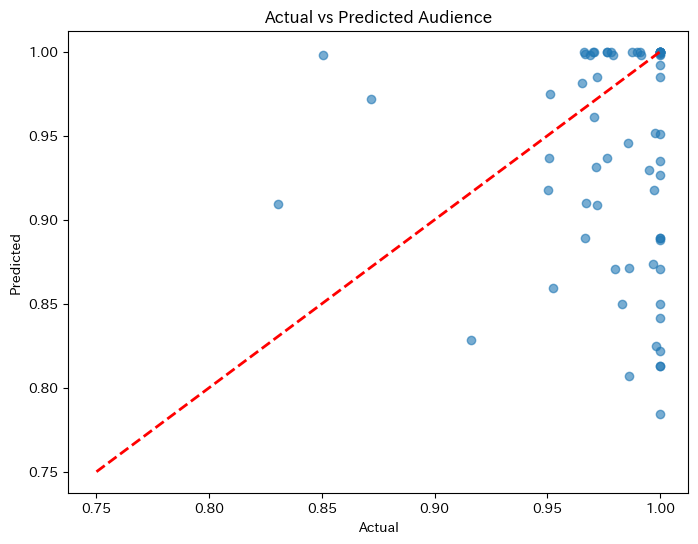

In [22]:
# 実際の観客数 vs 予測観客数
plt.figure(figsize=(8, 6))
plt.scatter(results.loc[:,"Actual"], results.loc[:,"Predicted"], alpha=0.6)
plt.plot([0.75, 1], [0.75, 1], 'r--', lw=2)  # 完璧な予測を示す直線
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Audience')
plt.savefig("../results/plots/Actual_VS_Predicted.png")
plt.show()

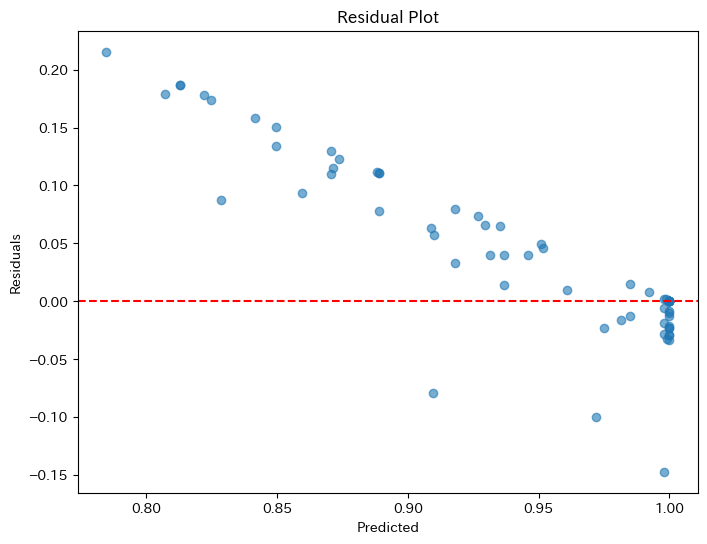

In [23]:
# 残差プロット (Residual Plot)
residuals = results.loc[:,"Actual"] - results.loc[:,"Predicted"]

plt.figure(figsize=(8, 6))
plt.scatter(results.loc[:,"Predicted"], residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.savefig("../results/plots/Residual_Plot.png")
plt.show()

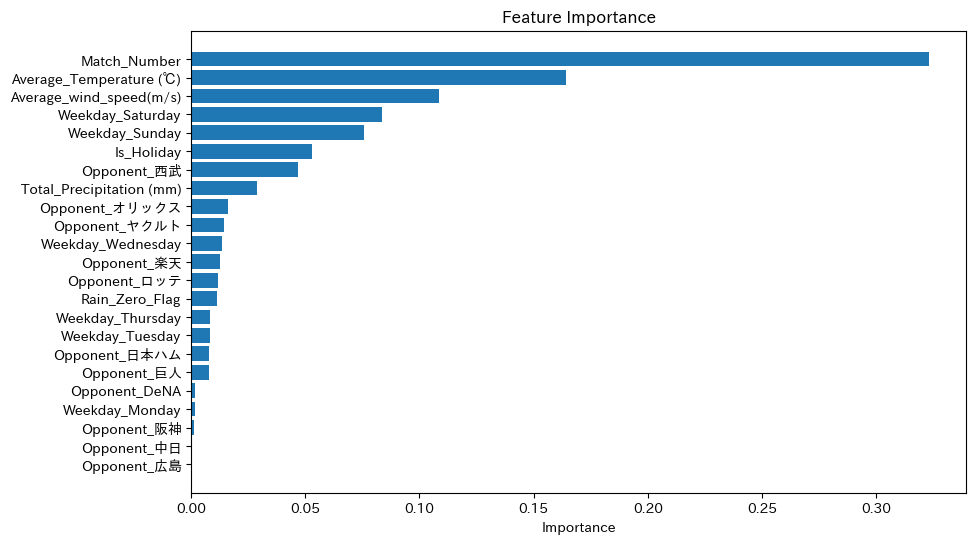

In [24]:
# 特徴量重要度の可視化
# モデルをロード
model = joblib.load('../results/models/decision_tree_model.pkl')
feature_importance = model.feature_importances_

# 特徴量の名前と重要度を対応させてDataFrameにする
feature_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=True)

# 可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')

plt.savefig("../results/plots/Feature_Importance.png")
plt.show()


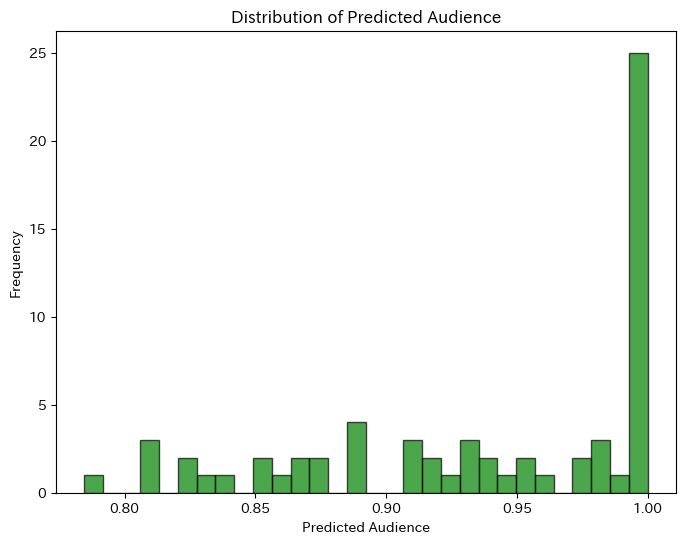

In [25]:
# 予測分布の可視化
plt.figure(figsize=(8, 6))
plt.hist(results.loc[:,"Predicted"], bins=30, alpha=0.7, color='g', edgecolor='black')
plt.xlabel('Predicted Audience')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Audience')
plt.savefig("../results/plots/Distribution.png")
plt.show()

In [26]:
# SHAP Explainerの作成
explainer = shap.TreeExplainer(model)
# SHAP値の計算
shap_values = explainer.shap_values(X_test)

# データの結合
combined = pd.concat([X_test, results], axis=1)
# 残差の計算
combined["Residuals"] = combined["Actual"] - combined["Predicted"]
# 残差が大きい順に並べ替え
sorted_combined = combined.sort_values(by="Residuals", ascending=False)
# 上位データの確認
indices = sorted_combined.head(5).index

# Force Plotを表示と保存
for i, idx in enumerate(indices):
    plt.figure(figsize=(10, 3))
    shap.force_plot(explainer.expected_value, shap_values[idx], X_test.iloc[idx], matplotlib=True, show=False)
    plt.savefig(f"../results/plots/Force_Plot_{i+1}.png", bbox_inches='tight', dpi=300)
    plt.close()

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

<Figure size 1000x300 with 0 Axes>

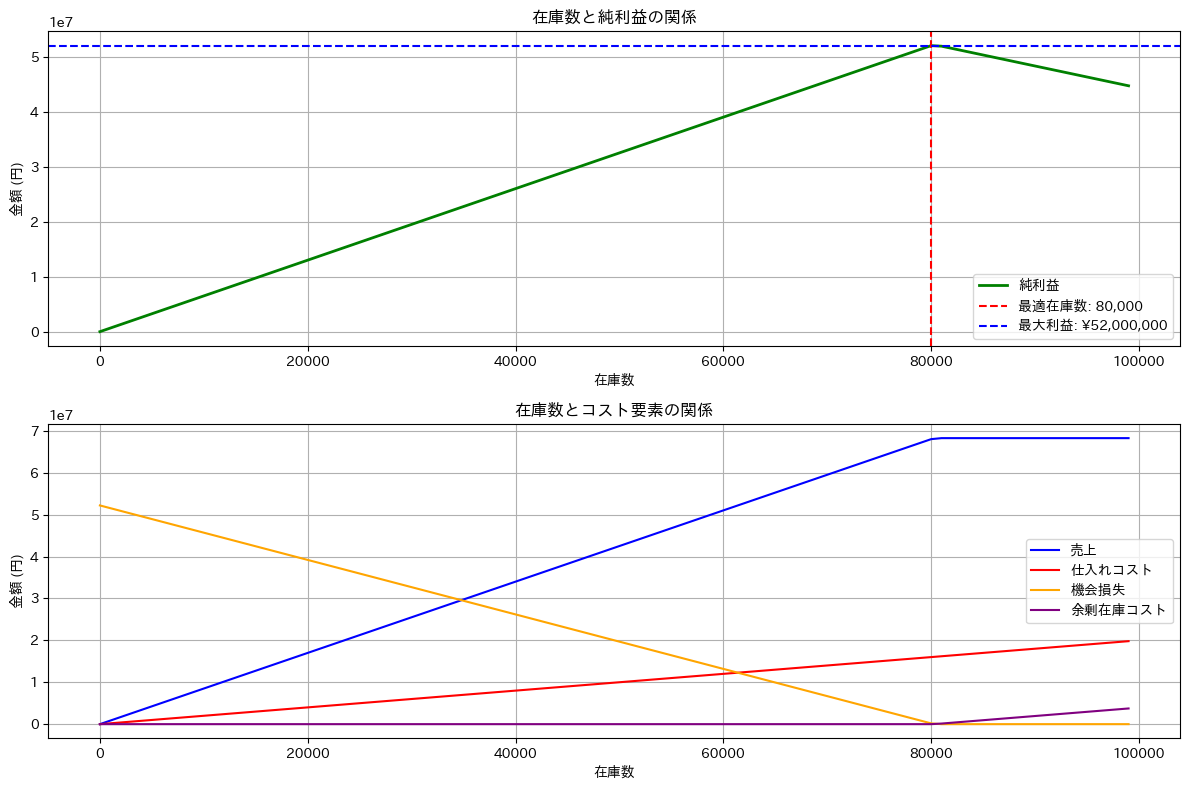


分析結果:
最適在庫数: 80,000
予測最大利益: ¥52,000,000


In [27]:
def analyze_inventory_optimization(audience, unit_price, purchase_rate, cost_per_unit, stock_range_max=100000, step=1000):
    """
    在庫最適化の分析を行う関数
    
    Parameters:
    -----------
    audience : int
        予測観客数
    unit_price : float
        販売単価
    purchase_rate : float
        1人当たりの購入数
    cost_per_unit : float
        仕入れ単価
    stock_range_max : int
        分析する最大在庫数
    step : int
        在庫数の刻み幅
    
    Returns:
    --------
    tuple : (最適在庫数, 最大利益, DataFrame(分析結果))
    """
    # 在庫数の範囲を設定
    stock_range = np.arange(0, stock_range_max, step)
    
    # 予測需要量（観客数 × 1人当たり購入数）
    expected_demand = audience * purchase_rate
    
    # 基本計算
    total_demand = expected_demand
    potential_sales = total_demand * unit_price
    
    # 各在庫水準での計算
    results = []
    for stock in stock_range:
        # 実際の販売数（在庫制約あり）
        actual_sales = min(stock, total_demand)
        
        # 売上
        revenue = actual_sales * unit_price
        
        # 仕入れコスト
        procurement_cost = stock * cost_per_unit
        
        # 機会損失（需要 - 実際の販売数）× 利益単価
        opportunity_loss = max(0, total_demand - stock) * (unit_price - cost_per_unit)
        
        # 余剰在庫コスト
        excess_stock = max(0, stock - total_demand)
        excess_cost = excess_stock * cost_per_unit
        
        # 純利益
        profit = revenue - procurement_cost - excess_cost
        
        results.append({
            '在庫数': stock,
            '売上': revenue,
            '仕入れコスト': procurement_cost,
            '機会損失': opportunity_loss,
            '余剰在庫コスト': excess_cost,
            '純利益': profit
        })
    
    # 結果をDataFrameに変換
    df_results = pd.DataFrame(results)
    
    # 最適在庫数と最大利益を特定
    optimal_stock = df_results.loc[df_results['純利益'].idxmax(), '在庫数']
    max_profit = df_results['純利益'].max()
    
    # グラフの作成
    plt.figure(figsize=(12, 8))
    
    # サブプロット1: 利益の推移
    plt.subplot(2, 1, 1)
    plt.plot(df_results['在庫数'], df_results['純利益'], label='純利益', color='green', linewidth=2)
    plt.axvline(x=optimal_stock, color='red', linestyle='--', label=f'最適在庫数: {optimal_stock:,.0f}')
    plt.axhline(y=max_profit, color='blue', linestyle='--', label=f'最大利益: ¥{max_profit:,.0f}')
    plt.xlabel('在庫数')
    plt.ylabel('金額 (円)')
    plt.title('在庫数と純利益の関係')
    plt.grid(True)
    plt.legend()
    
    # サブプロット2: コスト内訳
    plt.subplot(2, 1, 2)
    plt.plot(df_results['在庫数'], df_results['売上'], label='売上', color='blue')
    plt.plot(df_results['在庫数'], df_results['仕入れコスト'], label='仕入れコスト', color='red')
    plt.plot(df_results['在庫数'], df_results['機会損失'], label='機会損失', color='orange')
    plt.plot(df_results['在庫数'], df_results['余剰在庫コスト'], label='余剰在庫コスト', color='purple')
    plt.xlabel('在庫数')
    plt.ylabel('金額 (円)')
    plt.title('在庫数とコスト要素の関係')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    
    return optimal_stock, max_profit, df_results

# 分析実行例
audience = 40142  # 観客数
unit_price = 850  # 単価
purchase_rate = 2  # 1人当たり購入数
cost_per_unit = 200  # 仕入れ単価

optimal_stock, max_profit, results = analyze_inventory_optimization(
    audience=audience,
    unit_price=unit_price,
    purchase_rate=purchase_rate,
    cost_per_unit=cost_per_unit
)

plt.savefig("../results/plots/max_profit.png")
plt.show()

print(f"\n分析結果:")
print(f"最適在庫数: {optimal_stock:,.0f}")
print(f"予測最大利益: ¥{max_profit:,.0f}")

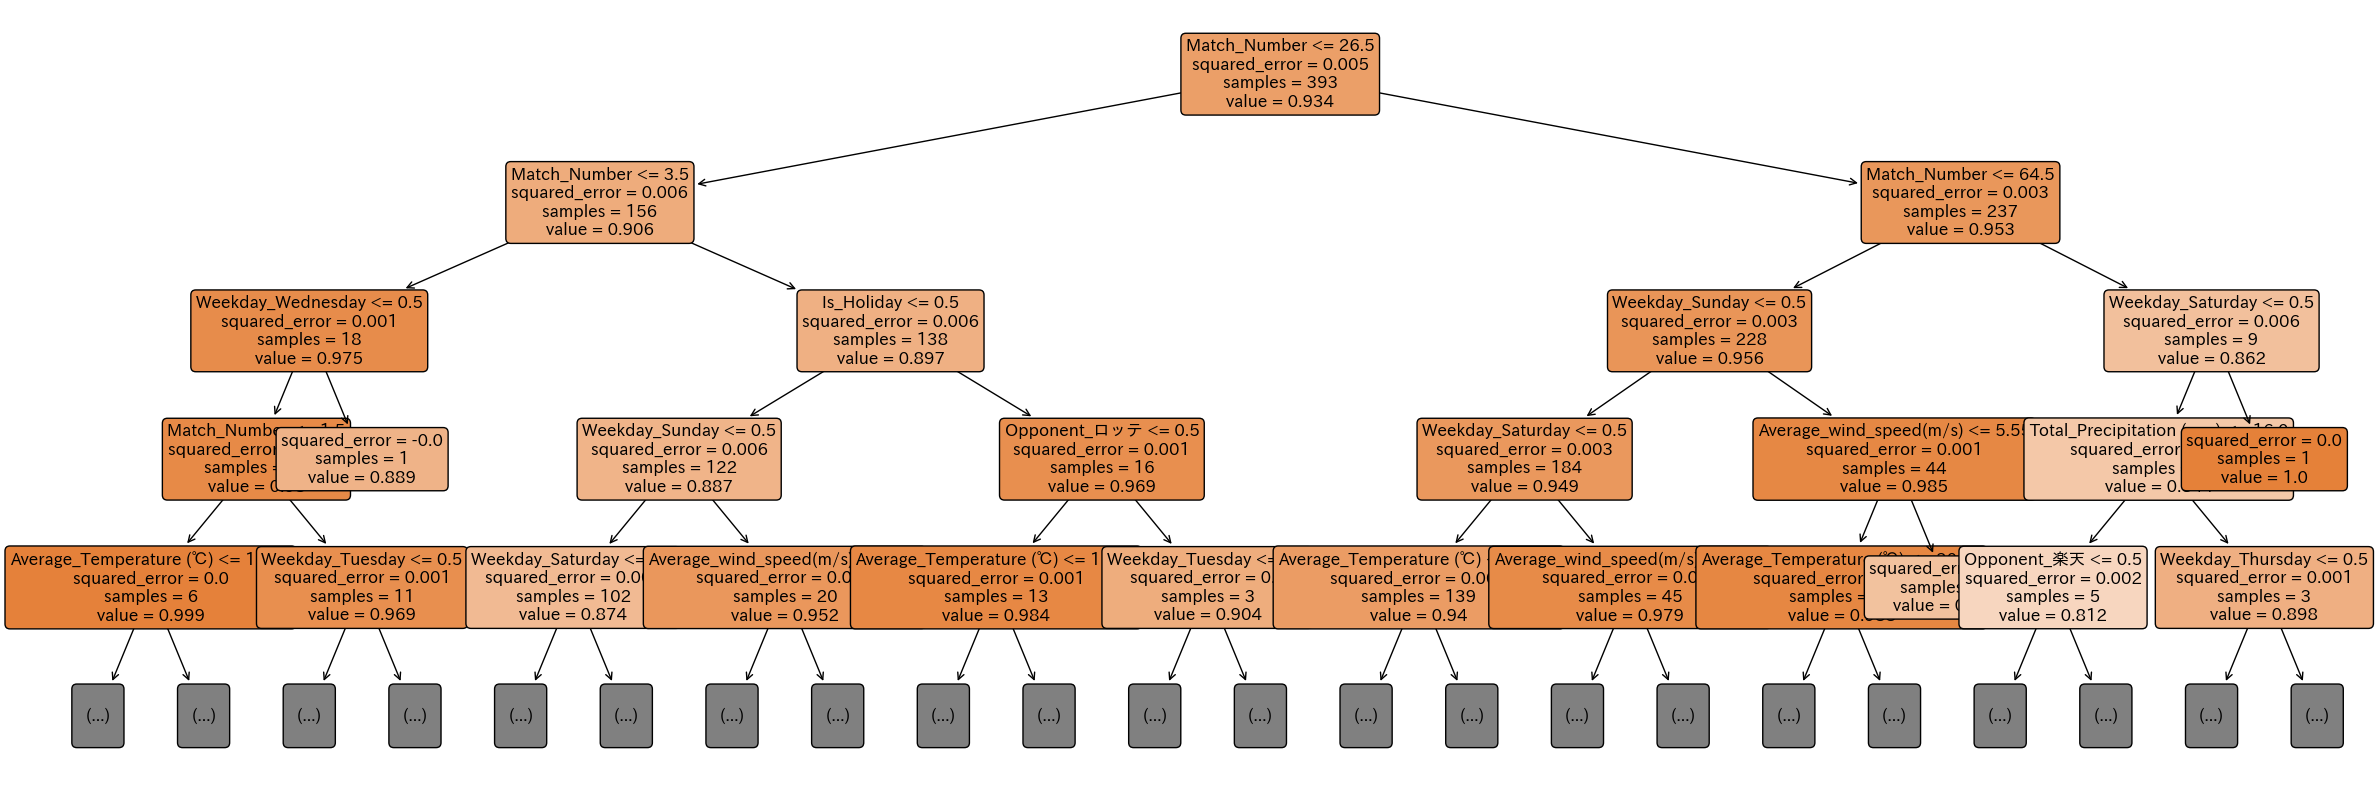

In [37]:
# 決定木の可視化
plt.figure(figsize=(30, 10))  # グラフのサイズを調整
plot_tree(model, 
          filled=True,  # ノードを色で塗りつぶす
          max_depth=4,  # 最初の5階層のみ表示
          feature_names=X_test.columns,  # 特徴量の名前を表示
          rounded=True,  # ノードを丸みを帯びた形に
          fontsize=12)  # フォントサイズを調整

# グラフを表示
plt.savefig("../results/plots/tree_visualization.png")
plt.show()